In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from datetime import datetime
from matplotlib.animation import FuncAnimation

from read import read_sims_result
from clean import cleanup_network,cleanup_0IR_exp

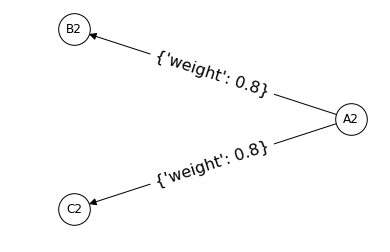

In [8]:
########################
# For a demo
########################
G01 = nx.DiGraph() 
G01.add_node("A2")
G01.add_node("B2")
G01.add_node("C2")
G01.add_edge("A2", "B2", weight=0.8)
G01.add_edge("A2", "C2", weight=0.8)
pos = nx.circular_layout(G01)
nx.draw_networkx_nodes(G01, pos, edgecolors="black", node_color="white", node_size=1000)
nx.draw_networkx_edges(G01, pos, edge_color="black", arrows=True, arrowsize=15, node_size=1000)
nx.draw_networkx_labels(G01, pos, node_size=1000)
nx.draw_networkx_edge_labels(G01, pos, font_size=16)
plt.axis('off')
plt.draw()

In [65]:
########################
# Make BETTER video Functions
########################

def animate_network(df = df, 
                    networks = df_1n,
                    data_birthday = "2018-06-25",
                    numIR=1,
                    numNode=32,
                    numPeriod=15,
                    sim_num = 22):

    # prepare variables
    numBank = numNode-1
    
    # make a string
    data_info = (str(numIR) + " Interest Rate " +
                 str(numBank) + " Bank " + 
                 str(numPeriod) + " Period"
                )
    
    # Get current time
    time_creation = datetime.now()
    time_displayed = time_creation.strftime('%Y-%m-%d %H:%M:%S')
    time_filename = time_creation.strftime("%Y%m%dT%H%M%S")

    # make a full graph
    fully_connected=np.ones((numBank,numBank))
    for i in range(numBank):
        fully_connected[i,i] = 0
    G = nx.DiGraph(fully_connected)

    # make the canvas
    fig = plt.figure(figsize=(11,11))
    plt.suptitle("Financial Credit Network\n" + data_info, fontsize=25)
    period = plt.text(s="o", x=0.91, y=-0.99, fontsize=22)
    plt.title(fontsize=11, 
              s=("Data ID: " + data_birthday
                + " Sim#" + str(sim_num)
                + " | Animation Created: " + time_displayed
                + " | Creator: Xinnan Cheng @ SRG"
                ) 
             )
    plt.axis('off')
#     plt.text(s="interest: red\nwealth:orange\ndeposit:pink",
#              x=-1, y=-1, fontsize=12)

    # nodes layout
    pos=nx.shell_layout(G) 

    # keep track of banks still alive
    alive_banks = set(range(numBank))
    # keep track of banks last dead
    last_dead = set([])

    # draw the nodes
    for n in G:
        G.node[n]['draw'] = nx.draw_networkx_nodes(G,
                                                   pos,
                                                   nodelist=[n], 
                                                   with_labels=False, 
                                                   node_color= (0,0,0),
                                                   node_shape= "h"
                                                  )
    # draw the invisible edges  
    for u,v in G.edges():
        G[u][v]['draw']=nx.draw_networkx_edges(G,
                                               pos,
                                               edgelist=[(u,v)],
                                               edge_color="white",
                                               alpha=0.0,
                                               arrows=True)[0]

    def update(p):  
        
        # if the bank defaulted last period, update the color
        for dead in last_dead:
            G.node[dead]['draw'].set_facecolor((1,1,1))
        last_dead.clear()

        # if the bank defaults, update the color, mark as dead
        for bank in list(alive_banks):

            interest, wealth, deposit \
            = df[np.array(df["sim#"]==sim_num) &
                 np.array(df["period"]==(p+1)) &
                 np.array(df["bankID"]==bank)
                ].iloc[0]["defaults due to interest":
                          "defaults due to deposit shock"]

            if interest + wealth + deposit != 0:
                alive_banks.remove(bank)
                last_dead.add(bank)
            if interest != 0: # red if default due to interest
                G.node[bank]['draw'].set_color((1,0,0))
            if wealth != 0: # orange if default due to negative wealth
                G.node[bank]['draw'].set_color((1,0.64,0))
            if deposit != 0: # pink if default due to deposit shock
                G.node[bank]['draw'].set_color((1,0,1))

        # update the edge color
        for debt, amount in np.ndenumerate(networks[sim_num, p]):
            
            # if there is debt, show it
            if amount>0 and debt[0] != debt[1]:
                G.edges[debt]['draw'].set_alpha(1.0)
                # map (0,inf) to (0,1)
                greeness = 1/(amount+1)
                G.edges[debt]['draw'].set_color((0,greeness,1))
                
            # if there is no debt, hide it
            if amount==0 and debt[0] != debt[1]:
                G.edges[debt]['draw'].set_alpha(0.0)

        # update the text (period)
        period.set_text("Period "+str(p+1))

        return ([node[1] for node in G.nodes(data="draw")] + 
                [edge[2] for edge in G.edges(data="draw")] + 
                [period])

    anim = FuncAnimation(fig, 
                         update, 
                         frames=numPeriod, 
                         interval=1000, 
                         repeat=False, 
                         blit=True)
    anim.save("network" + time_filename + ".mp4")

NameError: name 'df' is not defined

In [58]:
########################
# Reading & Cleaning input
########################
df = read_sims_result('/Users/xcheng/Documents/Oberlin/Summer2/DataAnalysis/data/0625/2IR', 32)
df_1n = cleanup_network(df, numNode=32, numPeriod=15, numSim=50)
df_1c = cleanup_0IR_exp(df, numNode=32, numPeriod=15, numSim=50, balanced=False)

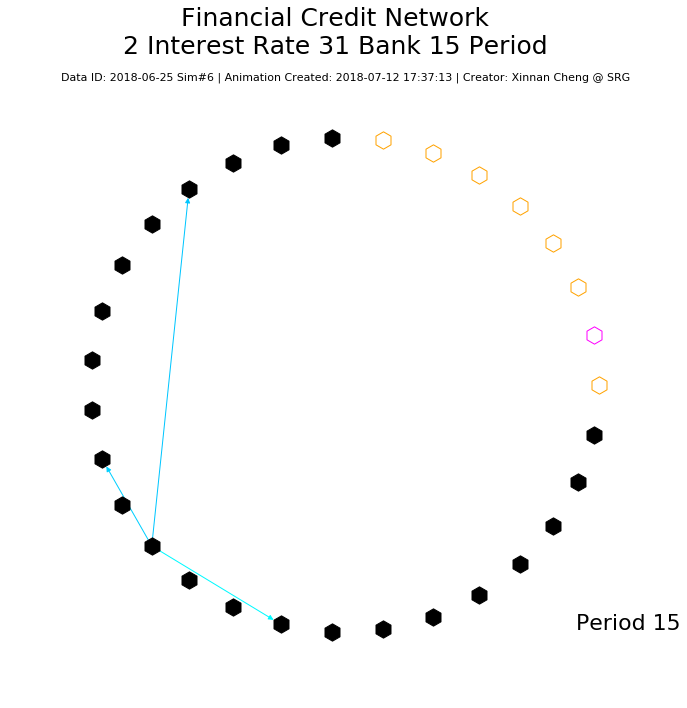

In [59]:
########################
# Make video
########################
animate_network(df = df, 
                networks = df_1n,
                data_birthday = "2018-06-25",
                numIR=2,
                numNode=32,
                numPeriod=15,
                sim_num=6)

Example result: https://www.youtube.com/watch?v=ZYM5uogKKek

In [76]:
########################
# Draw pictures and stitch (OLD STUFF)
########################

# G = nx.DiGraph()
# update_edge_matrix(G, df.loc[0:30, "dot1":"dot31"].values)
# pos=nx.spring_layout(G) 
# for i in range(15):
#     update_edge_matrix(G, df.loc[0:30, "dot1":"dot31"].values)

#     fig = plt.figure(figsize=(10,10))
#     plt.axis('off')
#     nx.draw_networkx_nodes(G,pos)
    
#     update_edge_matrix(G, df.loc[i*31:i*31+30, "dot1":"dot31"].values)
#     positive_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0]
#     nx.draw_networkx_edges(G, pos, arrows=True, edgelist=positive_edges) 
#     plt.text(-0.95,0.95,s="period "+str(i+1),fontsize=24)
#     plt.savefig("zzp-fig"+str(i)+".png")